This notebook performs a simple simulation of mitotic division.  Gene regulation is assumed to produce the same statistics as a random distribution.

In [2]:
from typing import Iterable

import numpy as np
import matplotlib.pyplot as plt

from pylineage import MultipleLineageSimulation2D

In [3]:
sim = MultipleLineageSimulation2D(2**10, 1)
sim.setup()
sim.run()

In [4]:
grid = sim.get_grid()
pos, cells = zip(*grid.items())

In [4]:
def find_root(cell):
    while cell.parent is not None:
        cell = cell.parent
    return cell

In [ ]:
root = find_root(cells[0])

(-22.85, 17.85, -21.25, 28.25)

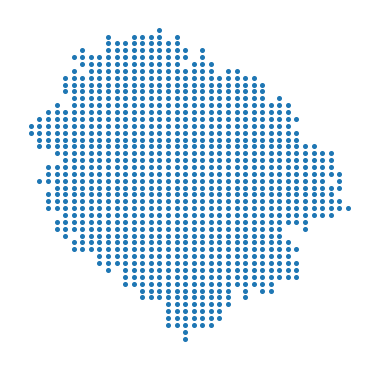

In [5]:
fig, ax = plt.subplots(figsize=(3,3), dpi=150)

x, y = zip(*pos)
ax.scatter(x, y, s=2)
ax.axis('off')

In [159]:
def divide_leaves(root):
    # We must first collect leaves in a list to prevent infinite recursion
    for leaf in list(root.leaves()):
        leaf.divide()
        
def grow_lineage(root, number_of_generations):
    for _ in range(number_of_generations):
        divide_leaves(root)
        
def cells_expression(root):
    return np.vstack([cell.expression for cell in root.descendants()])
        
def leaves_expression(root):
    return np.vstack([leaf.expression for leaf in root.leaves()])
        
def estimate_expression_from_leaves(root):
    return np.mean(leaves_expression(root), axis=0)

def estimated_expression(root):
    return [estimate_expression_from_leaves(cell)
            for cell in root.descendants()]

def estimation_error(root):
    return np.corrcoef(estimate_expression_from_leaves(root), root.expression)[0, 1]**2

In [160]:
N_GENERATIONS = 6
root = Cell()
grow_lineage(root, N_GENERATIONS)

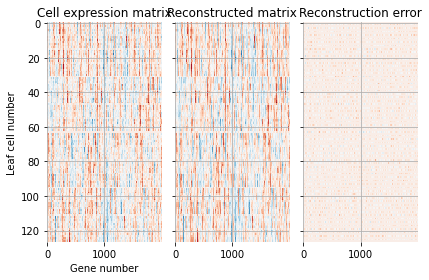

In [161]:
fig, (lax, cax, rax) = plt.subplots(ncols=3, sharey=True)

real = cells_expression(root)
estimated = estimated_expression(root)
difference = estimated - real

vmin = np.min(real)
vmax = np.max(real)

def draw_expression_matrix(ax, matrix):
    ax.imshow(matrix,
              aspect='auto',
              interpolation='none',
              cmap='RdBu',
              vmin=vmin, 
              vmax=vmax)

lax.set_title('Cell expression matrix')
cax.set_title('Reconstructed matrix')
rax.set_title('Reconstruction error')

draw_expression_matrix(lax, real)
draw_expression_matrix(cax, estimated)
draw_expression_matrix(rax, difference)

lax.set_xlabel('Gene number')
lax.set_ylabel('Leaf cell number')
fig.tight_layout()

In [162]:
depths = list(range(root.height + 1))
error_per_depth = [[] for _ in depths]
for cell in root.descendants():
    error_per_depth[cell.depth].append(estimation_error(cell))

/Users/stankerstjens/repos/paper-address-space/venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/stankerstjens/repos/paper-address-space/venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


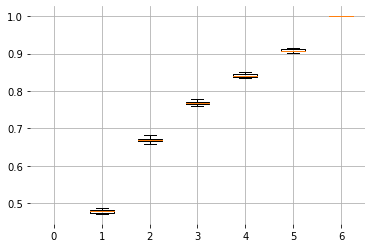

In [163]:
plt.boxplot(error_per_depth, positions=depths);

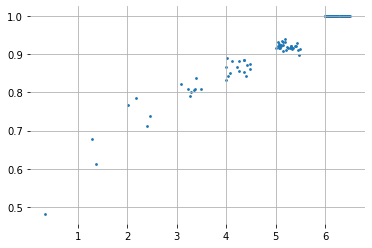

In [120]:
plt.scatter(depth + np.random.rand(len(depth)) / 2, error, s=3)

In [158]:


class Cell:
    """A cell with a vector of gene expression.
    """
    N_GENES = 2000
    
    def __init__(self, parent=None, expression=None) -> None:
        
        # if no expression is specified (e.g. for the root cell of a lineage
        # tree) the expression defaults to a random vector.
        if expression is None:
            expression = np.zeros(self.N_GENES)
            
        self.expression = expression
        self.children = ()
        self.parent = parent
        
    def _make_child(self) -> 'Cell':
        """Creates a child whose gene expression"""
        return Cell(self, self.expression + self.random_expression())
    
    @classmethod
    def random_expression(cls):
        '''Returns a random expression vector with zero mean and unit variance.'''
        return np.random.randn(cls.N_GENES)
    
    @property
    def is_leaf(self) -> bool:
        return len(self.children) == 0
    
    @property
    def n_genes(self) -> int:
        return len(self.expression)
    @property
    def depth(self) -> int:
        return 0 if self.parent is None else self.parent.depth + 1
    @property
    def height(self) -> int:
        return max(leaf.depth for leaf in self.leaves())
    def divide(self) -> None:
        self.children = (self._make_child(), self._make_child())
    
    def descendants(self) -> Iterable['Cell']:
        if len(self.children) > 0:
            yield from self.children[0].descendants()
        yield self
        if len(self.children) > 1:
            yield from self.children[1].descendants()
            
    def leaves(self) -> Iterable['Cell']:
        yield from filter(lambda c: c.is_leaf, self.descendants())
        
    def __str__(self):
        return f'Cell(n_genes={self.n_genes},is_leaf={self.is_leaf},depth={self.depth})'
    def __repr__(self):
        return str(self)